In [116]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from ydata_profiling import ProfileReport
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer

## Classification task
### Data extraction and EDA

In [135]:
orders_data = pd.read_json("order_cancellation_data.json")
orders_data.head()

order_status   order_create_time  total_order_items  tot_unique_items  \
0            F 2023-08-19 00:00:06                  3                 3   
1            F 2023-08-19 00:00:12                 10                 5   
2            F 2023-08-19 00:00:19                 12                 6   
3            F 2023-08-19 00:00:27                  2                 2   
4            F 2023-08-19 00:00:41                  1                 1   

   cost(USD)  vendor_id payment_type  vendor_client_distance  \
0      14.84       5929        Other                  3524.0   
1      22.30       4755        Other                   753.0   
2      18.70       5091         card                  2604.0   
3       6.48       3543        Other                 12920.0   
4       5.33       9279        Other                  1728.0   

   estimated_delivery_time  predicted_order_preparation_time  
0                    102.0                              34.0  
1                     45.0                              14.0  
2                     70.0                              30.0  
3                     73.0                              24.0  
4                     47.0                               5.0

In [4]:
orders_data.dtypes

order_status                                object
order_create_time                   datetime64[ns]
total_order_items                            int64
tot_unique_items                             int64
cost(USD)                                  float64
vendor_id                                    int64
payment_type                                object
vendor_client_distance                     float64
estimated_delivery_time                    float64
predicted_order_preparation_time           float64
dtype: object

In [7]:
print(f"The number of duplicates in the data: {orders_data.duplicated().sum()}")

The number of duplicates in the data: 0


Let's check most of the metrics using ydata_profiling

In [12]:
orders_profile_reprot = ProfileReport(orders_data)

orders_profile_reprot.to_file("orders_profile_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

From the profile report we see that there's a lot of missing values in the dataset, and the data is highly imbalanced

In [17]:
print(f"missing values:")
print()
print(f"{orders_data.isnull().sum()}")

missing values:

order_status                            0
order_create_time                       0
total_order_items                       0
tot_unique_items                        0
cost(USD)                              27
vendor_id                               0
payment_type                            7
vendor_client_distance              36453
estimated_delivery_time             36492
predicted_order_preparation_time    39295
dtype: int64


Deletion the values wiht missing values in payment type and
encoding of payment type feature with one hot encoder

In [120]:
orders_data["payment_type"].value_counts(dropna=False)

Other    186840
card     103396
None          7
Name: payment_type, dtype: int64

In [136]:
orders_data = orders_data[~orders_data["payment_type"].isna()]
orders_data["payment_type"].value_counts(dropna=False)

Other    186840
card     103396
Name: payment_type, dtype: int64

In [137]:
ohe = OneHotEncoder(cols=["payment_type"])

orders_data = ohe.fit_transform(orders_data)
orders_data.head()

order_status   order_create_time  total_order_items  tot_unique_items  \
0            F 2023-08-19 00:00:06                  3                 3   
1            F 2023-08-19 00:00:12                 10                 5   
2            F 2023-08-19 00:00:19                 12                 6   
3            F 2023-08-19 00:00:27                  2                 2   
4            F 2023-08-19 00:00:41                  1                 1   

   cost(USD)  vendor_id  payment_type_1  payment_type_2  \
0      14.84       5929               1               0   
1      22.30       4755               1               0   
2      18.70       5091               0               1   
3       6.48       3543               1               0   
4       5.33       9279               1               0   

   vendor_client_distance  estimated_delivery_time  \
0                  3524.0                    102.0   
1                   753.0                     45.0   
2                  2604.0                     70.0   
3                 12920.0                     73.0   
4                  1728.0                     47.0   

   predicted_order_preparation_time  
0                              34.0  
1                              14.0  
2                              30.0  
3                              24.0  
4                               5.0

## Imputation of missing numerical values

Also from the profiling report it is clear that there's a lot of null values in features like:
* totat_order_items
* cost_usd
* vendor_client_distance
* estimated_delievery_time

We can make an assumption that values of all these features were assigned to 0.
Let's try to check this

In [78]:
orders_data[(orders_data["order_status"] == "C")].count()

order_status                        37360
order_create_time                   37360
total_order_items                   37360
tot_unique_items                    37360
cost(USD)                           37333
vendor_id                           37360
payment_type                        37358
vendor_client_distance               1731
estimated_delivery_time              1728
predicted_order_preparation_time       17
dtype: int64

Now, let's impute this values

In [138]:
missing_cols = ["vendor_client_distance", "estimated_delivery_time", "predicted_order_preparation_time", "cost(USD)"]
for col in missing_cols:
    orders_data[col] = orders_data[col].fillna(orders_data[col].median())
orders_data.isnull().sum()

order_status                        0
order_create_time                   0
total_order_items                   0
tot_unique_items                    0
cost(USD)                           0
vendor_id                           0
payment_type_1                      0
payment_type_2                      0
vendor_client_distance              0
estimated_delivery_time             0
predicted_order_preparation_time    0
dtype: int64

## Extraction of features from date-time

Also all the deliveries were made in 2023 so we should drop the year value in the datetime feature

In [139]:
orders_data["order_create_time"] = pd.to_datetime(orders_data["order_create_time"])
orders_data["order_create_month"] =  pd.to_datetime(orders_data["order_create_time"]).dt.month
orders_data["order_create_day"] =  pd.to_datetime(orders_data["order_create_time"]).dt.day
orders_data["order_create_hour"] =  pd.to_datetime(orders_data["order_create_time"]).dt.hour
orders_data.sort_values(by=["order_create_time"], ascending=True, inplace=True)
orders_data.drop(["order_create_time"], axis=1, inplace=True)
orders_data.head()

order_status  total_order_items  tot_unique_items  cost(USD)  vendor_id  \
0            F                  3                 3      14.84       5929   
1            F                 10                 5      22.30       4755   
2            F                 12                 6      18.70       5091   
3            F                  2                 2       6.48       3543   
4            F                  1                 1       5.33       9279   

   payment_type_1  payment_type_2  vendor_client_distance  \
0               1               0                  3524.0   
1               1               0                   753.0   
2               0               1                  2604.0   
3               1               0                 12920.0   
4               1               0                  1728.0   

   estimated_delivery_time  predicted_order_preparation_time  \
0                    102.0                              34.0   
1                     45.0                              14.0   
2                     70.0                              30.0   
3                     73.0                              24.0   
4                     47.0                               5.0   

   order_create_month  order_create_day  order_create_hour  
0                   8                19                  0  
1                   8                19                  0  
2                   8                19                  0  
3                   8                19                  0  
4                   8                19                  0

## Scaling features

In [140]:
X = orders_data.drop(["order_status"], axis=1)
y = orders_data["order_status"]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, shuffle=False)
X_train.shape, X_test.shape

((261212, 12), (29024, 12))

In [141]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)
X_train.head()

total_order_items  tot_unique_items  cost(USD)  vendor_id  payment_type_1  \
0                0.0               0.0   1.113445   0.171523             0.0   
1                3.5               1.0   2.158263  -0.125918             0.0   
2                4.5               1.5   1.654062  -0.040790            -1.0   
3               -0.5              -0.5  -0.057423  -0.432987             0.0   
4               -1.0              -1.0  -0.218487   1.020269             0.0   

   payment_type_2  vendor_client_distance  estimated_delivery_time  \
0             0.0                0.145802                 1.481481   
1             0.0               -0.911832                -0.629630   
2             1.0               -0.205344                 0.296296   
3             0.0                3.732061                 0.407407   
4             0.0               -0.539695                -0.555556   

   predicted_order_preparation_time  order_create_month  order_create_day  \
0                          1.555556                -1.0          0.235294   
1                         -0.666667                -1.0          0.235294   
2                          1.111111                -1.0          0.235294   
3                          0.444444                -1.0          0.235294   
4                         -1.666667                -1.0          0.235294   

   order_create_hour  
0          -2.285714  
1          -2.285714  
2          -2.285714  
3          -2.285714  
4          -2.285714

## Data visualization

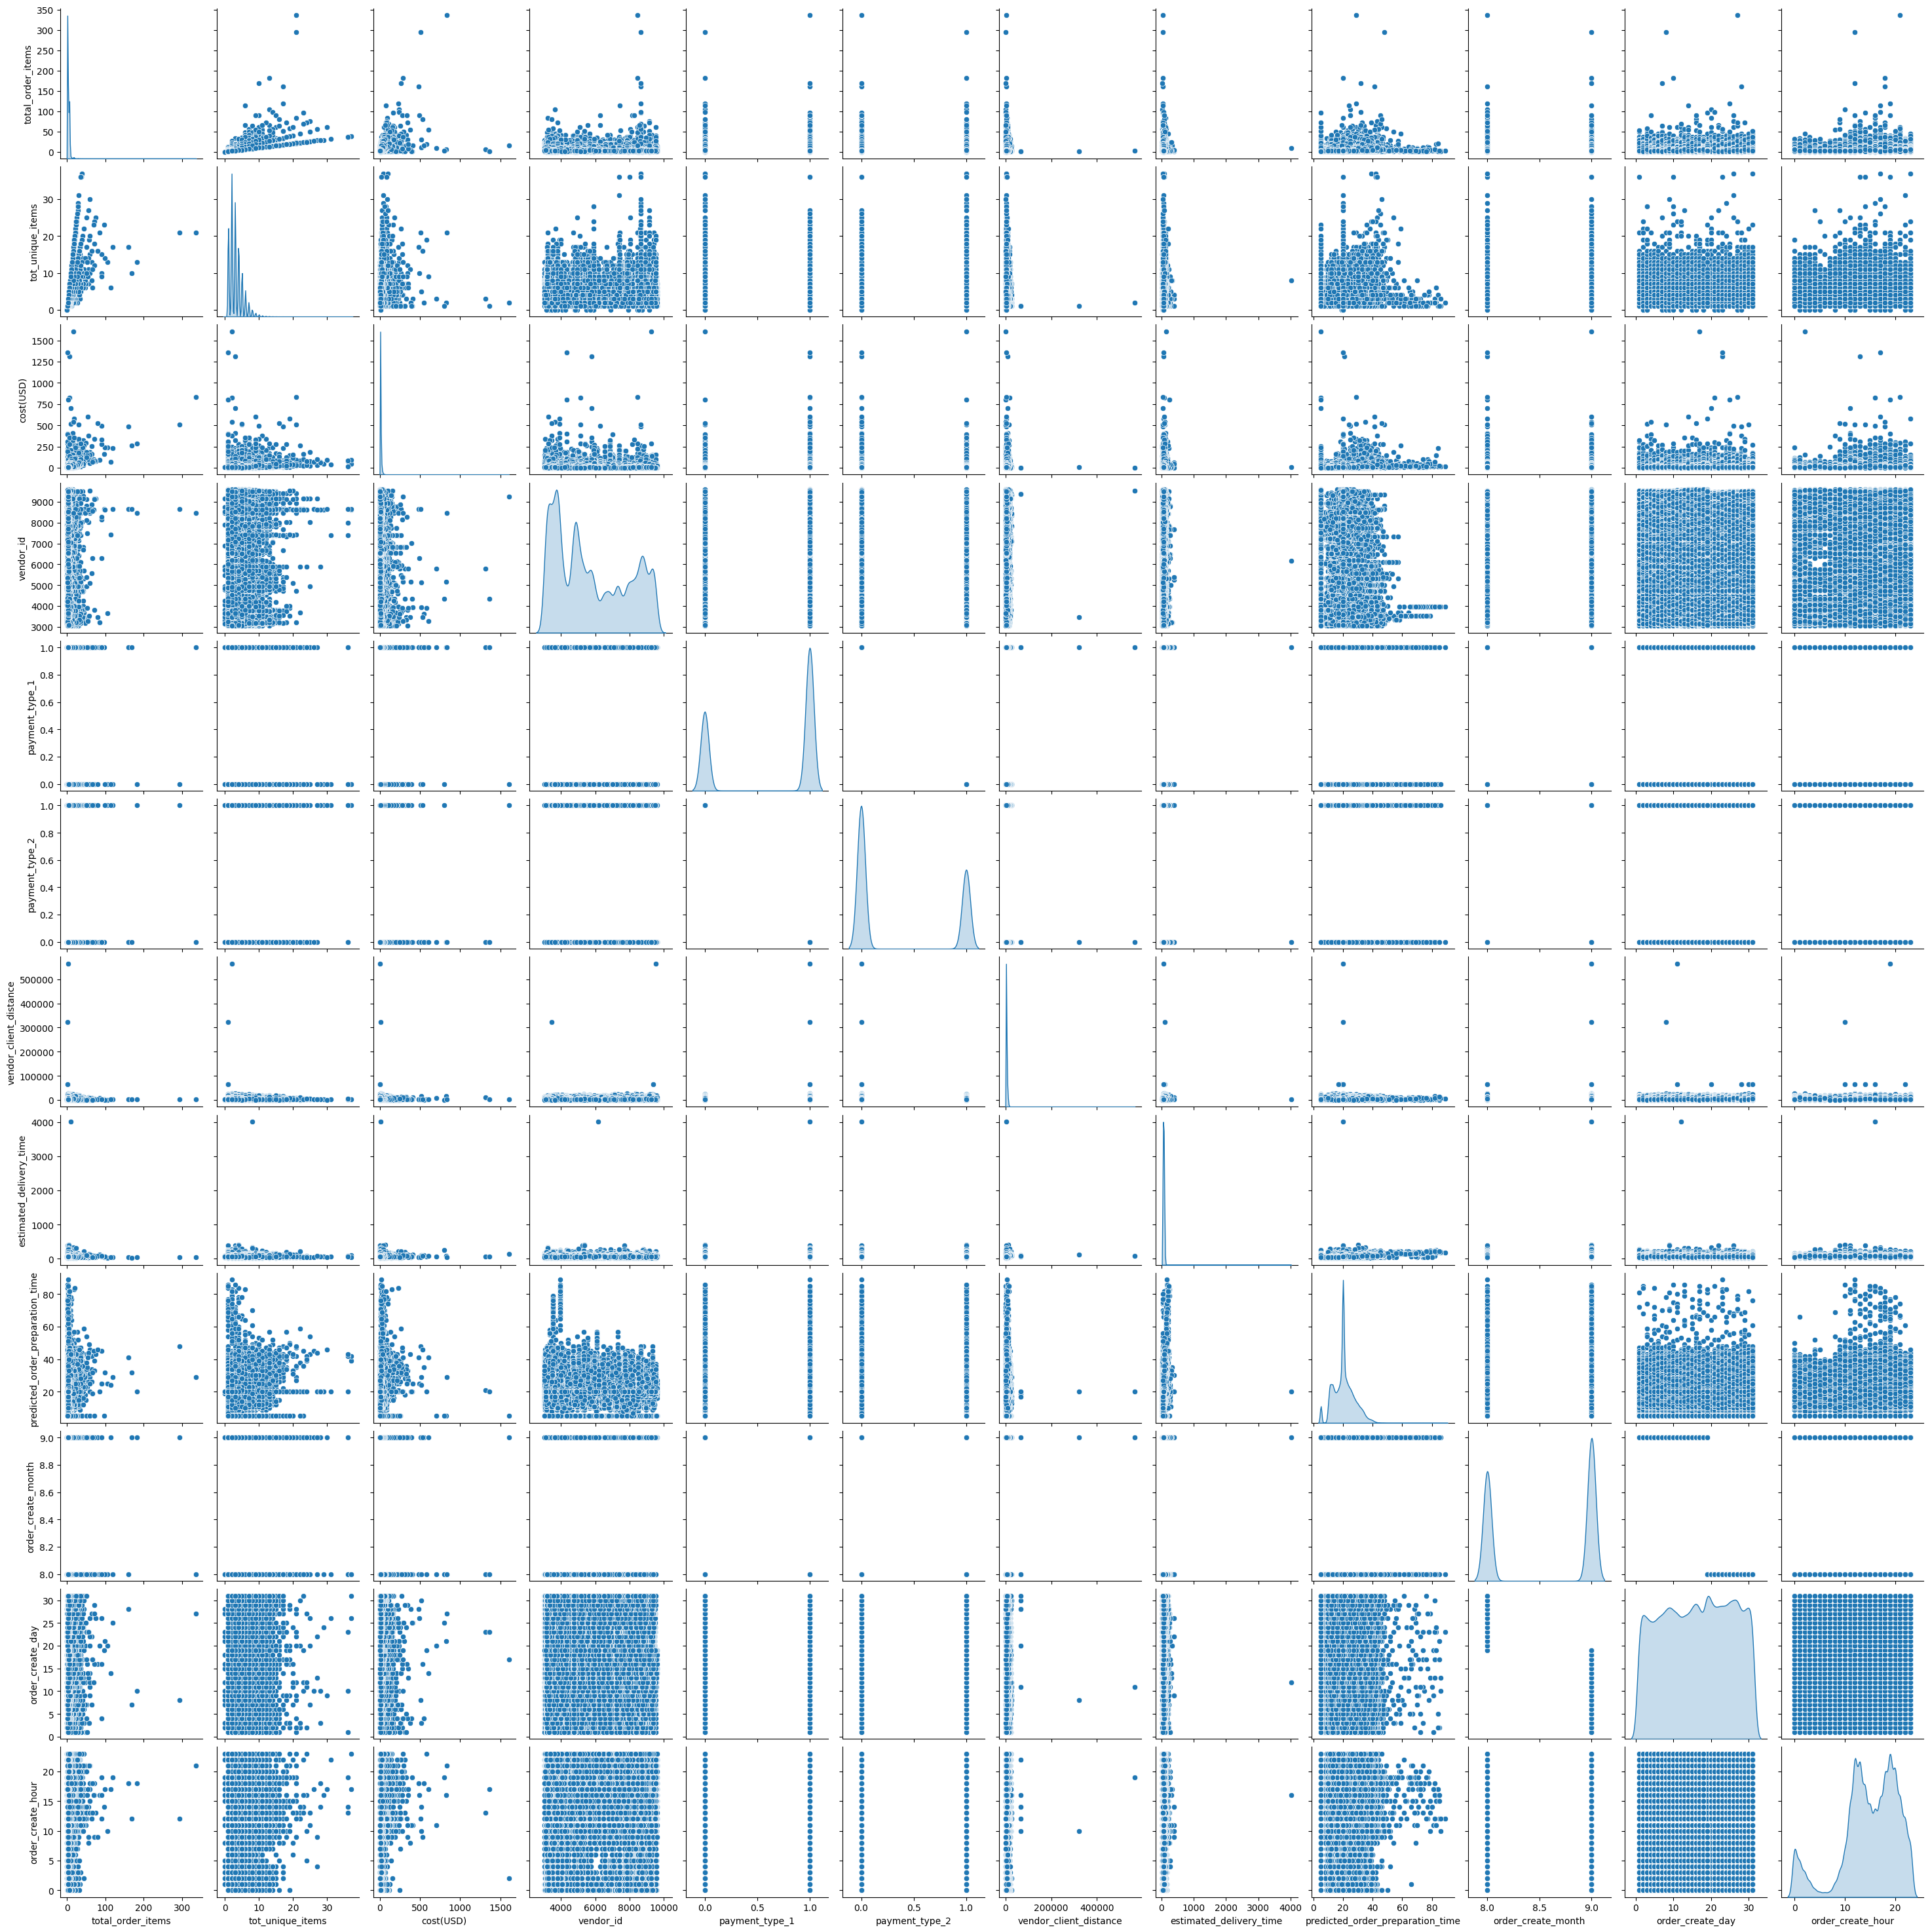

In [146]:
%matplotlib inline
sns.pairplot(orders_data,diag_kind="kde")

<AxesSubplot: >

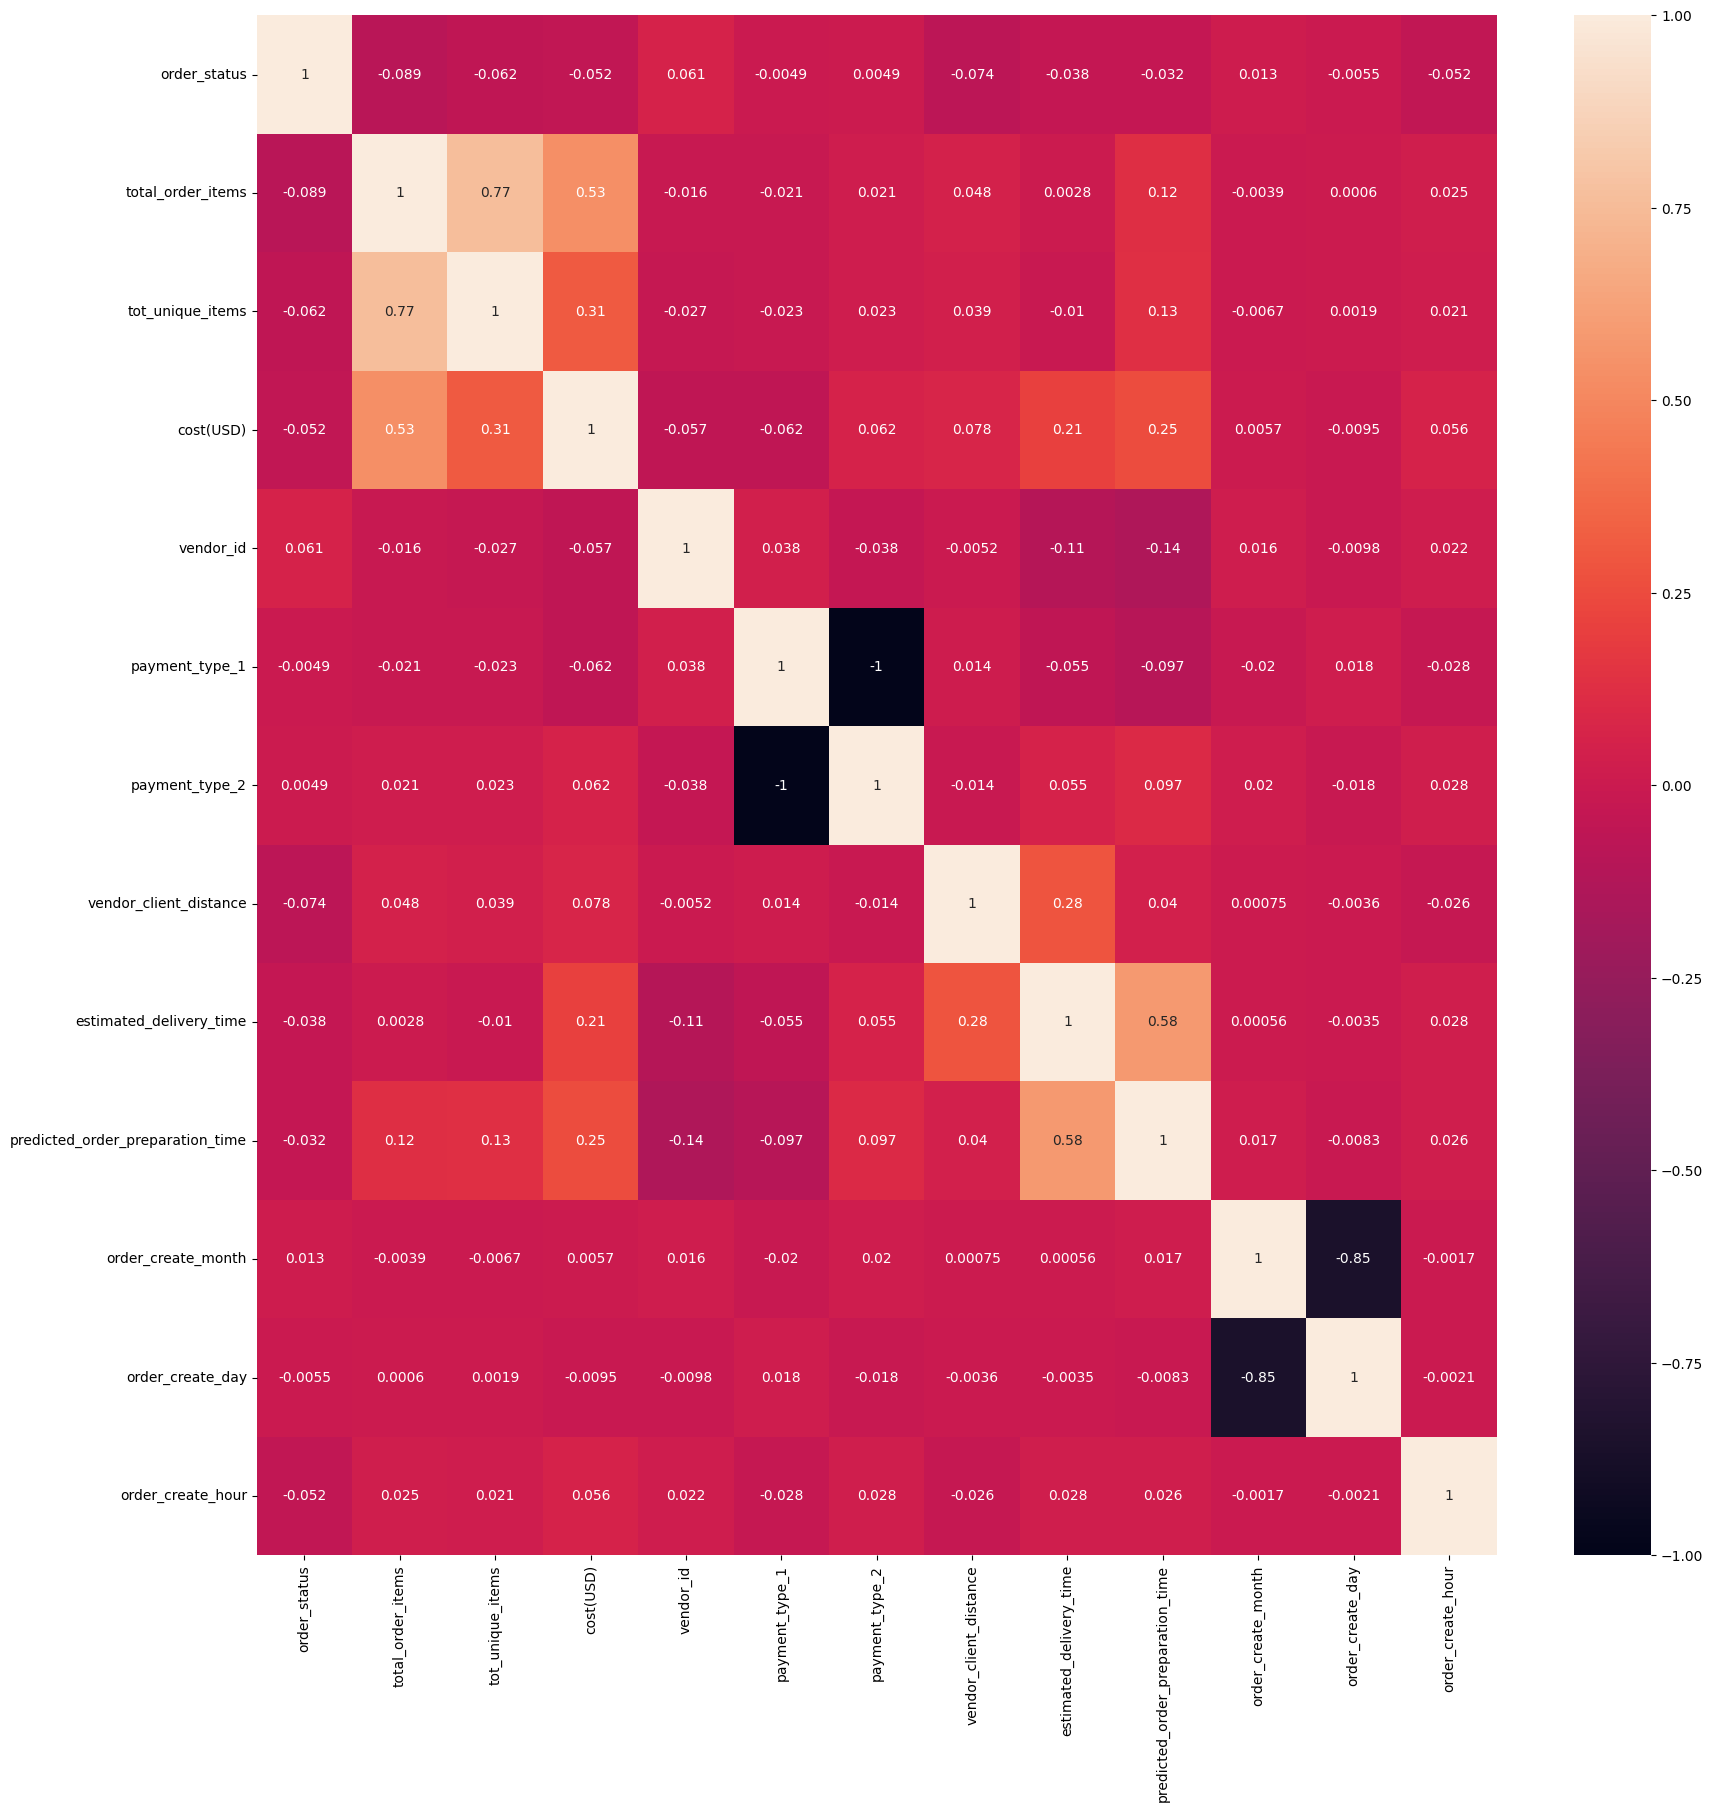

In [147]:
plt.figure(figsize=(20, 20))
orders_data_2 = orders_data.copy()
orders_data_2["order_status"] = orders_data_2["order_status"].apply(lambda x: 0 if x == 'F' else 1)
sns.heatmap(orders_data_2.corr(), annot=True)

From the pairwise plots and correlation heatmap we see that vendor_id has low correlation with the target feature, so we will drop it

In [148]:
X_train.drop(["vendor_id"], axis=1, inplace=True)
X_test.drop(["vendor_id"], axis=1, inplace=True)

From the profile report we see that there's a hight differebce between cancelled and finished orders. Lets plot it.

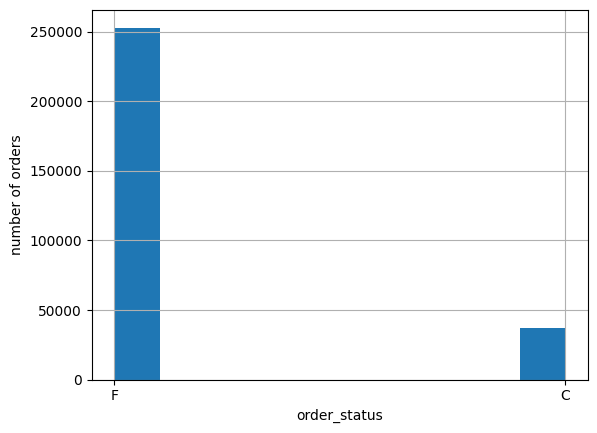

In [145]:
y.hist()

plt.xlabel("order_status")
plt.ylabel("number of orders")

plt.show()

## Classification

In [162]:
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report

model = LogisticRegression(penalty='l2', C=1, max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"Precision: {precision_score(y_test, y_pred, average="macro")}")
print(f"Recall: {recall_score(y_test, y_pred, average="macro")}")
print(f"F1-score: {f1_score(y_test, y_pred, average="macro")}")
print(classification_report(y_test, y_pred))

/Users/ildarzalaliev/Desktop/ML/Assignment 1 (Task)-20231002/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.4319528665931643
Recall: 0.5
F1-score: 0.4634921808569633


/Users/ildarzalaliev/Desktop/ML/Assignment 1 (Task)-20231002/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           C       0.00      0.00      0.00      3950
           F       0.86      1.00      0.93     25074

    accuracy                           0.86     29024
   macro avg       0.43      0.50      0.46     29024
weighted avg       0.75      0.86      0.80     29024



/Users/ildarzalaliev/Desktop/ML/Assignment 1 (Task)-20231002/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ildarzalaliev/Desktop/ML/Assignment 1 (Task)-20231002/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Classification with oversampling

In [155]:
!pip install imblearn

  Using cached imblearn-0.0-py2.py3-none-any.whl (1.9 kB)
  Obtaining dependency information for imbalanced-learn from https://files.pythonhosted.org/packages/a3/9e/fbe60a768502af54563dcb59ca7856f5a8833b3ad5ada658922e1ab09b7f/imbalanced_learn-0.11.0-py3-none-any.whl.metadata
  Using cached imbalanced_learn-0.11.0-py3-none-any.whl.metadata (8.3 kB)
Using cached imbalanced_learn-0.11.0-py3-none-any.whl (235 kB)


In [156]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train, y_train)
y_train_oversampled.value_counts()

F    227804
C    227804
Name: order_status, dtype: int64

In [163]:
model = LogisticRegression(penalty='l2', C=10, max_iter=1000)
model.fit(X_train_oversampled, y_train_oversampled)
y_pred = model.predict(X_test)

print(f"Precision: {precision_score(y_test, y_pred, average="macro")}")
print(f"Recall: {recall_score(y_test, y_pred, average="macro")}")
print(f"F1-score: {f1_score(y_test, y_pred, average="macro")}")
print(classification_report(y_test, y_pred))

Precision: 0.5791741648677421
Recall: 0.6589796682831477
F1-score: 0.4560027511924911
              precision    recall  f1-score   support

           C       0.20      0.89      0.32      3950
           F       0.96      0.43      0.59     25074

    accuracy                           0.49     29024
   macro avg       0.58      0.66      0.46     29024
weighted avg       0.86      0.49      0.55     29024

